In [1]:
import json
import os

import cv2
import matplotlib
import numpy as np
import pandas as pd
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, Lambda
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

%matplotlib inline
matplotlib.style.use('ggplot')

TARGET_SIZE = (64, 64)
BATCH_SIZE = 32

image_dir = './data/'
driving_log_csv = './data/driving_log.csv'
model_json = 'model.json'
model_weights = 'model.h5'

Using TensorFlow backend.


In [2]:
def normalize(X):
    X /= 255.0
    return X


def equalize_channel(X):
    for i in range(0, 3):
        channel = X[:, :, i]
        channel = channel.astype(np.uint8)
        channel = cv2.equalizeHist(channel)
        X[:, :, i] = channel
    return X


def crop_and_resize(image):
    '''
    : The input image of dimensions 160x320x3
    : return: Output image of size 64x64x3
    '''
    cropped_image = image[55:135, :, :]
    processed_image = resize_to_target_size(cropped_image)
    return processed_image


def resize_to_target_size(image):
    return cv2.resize(image, TARGET_SIZE)


def augment_brightness(image):
    '''
    :param image: Input image
    :return: output image with reduced brightness
    '''
    # convert to HSV so that its easy to adjust brightness
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # randomly generate the brightness reduction factor
    # Add a constant so that it prevents the image from being completely dark
    random_bright = .25 + np.random.uniform()

    # Apply the brightness reduction to the V channel
    image1[:, :, 2] = image1[:, :, 2] * random_bright

    # convert to RBG again
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1


def pre_process(image_path):
    image = load_img(image_path.strip())
    image = img_to_array(image)
    normalize(image)
    image = crop_and_resize(image)
#     image = equalize_channel(image)
    image = augment_brightness(image)
    image = image.astype(np.float32)
    # Normalize image
#     image = image / 255.0 - 0.5
    return image


In [3]:
# load some images for display
# [center,left,right,steering,throttle,brake,speed]
import csv
def read_driving_log():
    center_images = {}
    left_images = {}
    right_images = {}
    i =0
    with open(driving_log_csv) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if (float(row['steering']) == 0) : continue
                
            i+=1
            center_images[float(row['steering'])] = image_dir + row['center'].strip()
            left_images[float(row['steering'])] = image_dir + row['left'].strip()
            right_images[float(row['steering'])] = image_dir + row['right'].strip()
            
            if i == 5: break
        
    return center_images, left_images, right_images

center_imgs, left_imgs, right_imgs = read_driving_log()

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

get_ipython().magic('matplotlib inline')
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

def plot_images(images_data):
    plt.figure(figsize=(15,15))
    i=0
    for steering_angle, image_path in images_data.items():
        pre_image = pre_process(image_path)
        plt.subplot(5,5,i+1)
        plt.subplots_adjust(left=0.15)
        plt.imshow(pre_image)
        plt.text(0, -2, steering_angle, fontdict=font)
        i+=1

## Visualize Pre-processed Camera Center images along with the steering angle

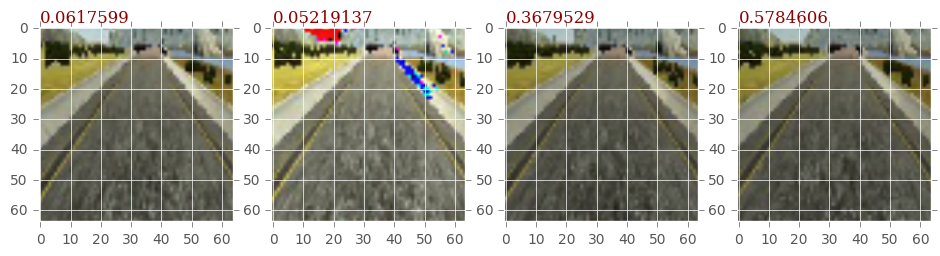

In [5]:
plot_images(center_imgs)

## Visualize  Pre-processed Left camera images with its steering angles

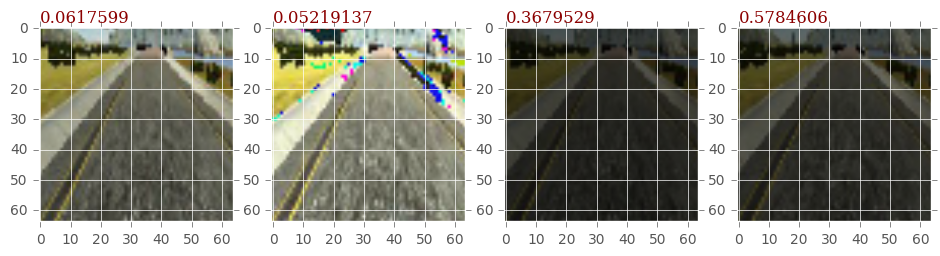

In [6]:
plot_images(left_imgs)

## Visualize  Pre-processed Right Camera Images along with Steering angles

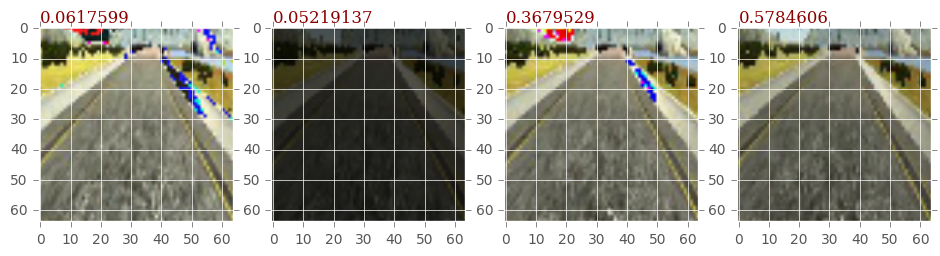

In [7]:
plot_images(right_imgs)

In [8]:
def get_augmented_row(row):
    steering = row['steering']

    # randomly choose the camera_chosen to take the image from
    camera_chosen = np.random.choice(['center', 'left', 'right'])

    # adjust the steering angle for left anf right cameras
    if camera_chosen == 'left':
        steering += 0.25
    elif camera_chosen == 'right':
        steering -= 0.25

    # image = load_img(data_dir + row[camera_chosen].strip())
    # image = img_to_array(image)

    # Crop, resize and normalize the image
    image = pre_process(image_dir + row[camera_chosen].strip())
    image, steering = flip_image(image, steering)

    return image, steering


def flip_image(image, steering):
    # decide whether to horizontally flip the image:
    # This is done to reduce the bias for turning left that is present in the training data
    flip_prob = np.random.random()
    if flip_prob > 0.5:
        # flip the image and reverse the steering angle
        steering *= -1
        image = cv2.flip(image, 1)
        

    return image, steering

   ## Data generator for images

In [9]:
def get_data_generator(data_frame, batch_size=32):
    N = data_frame.shape[0]
    batches_per_epoch = N // batch_size

    i = 0
    while (True):
        start = i * batch_size
        end = start + batch_size - 1

        X_batch = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
        y_batch = np.zeros((batch_size,), dtype=np.float32)

        j = 0

        # slice a `batch_size` sized chunk from the dataframe
        # and generate augmented data for each row in the chunk on the fly
        for index, row in data_frame.loc[start:end].iterrows():
            X_batch[j], y_batch[j] = get_augmented_row(row)
            j += 1

        i += 1
        if i == batches_per_epoch - 1:
            # reset the index so that we can cycle over the data_frame again
            i = 0
        yield X_batch, y_batch

## Create with data generator

In [10]:
all_driving_log_rows = pd.read_csv(driving_log_csv, usecols=[0, 1, 2, 3])

# shuffle the data
all_driving_log_rows = all_driving_log_rows.sample(frac=1).reset_index(drop=True)

# 80-20 training validation split
training_split = 0.8

num_rows_training = int(all_driving_log_rows.shape[0] * training_split)

training_data = all_driving_log_rows.loc[0:num_rows_training - 1]
validation_data = all_driving_log_rows.loc[num_rows_training:]

# release the main data_frame from memory
all_driving_log_rows = None

training_generator = get_data_generator(training_data, batch_size=BATCH_SIZE)
validation_data_generator = get_data_generator(validation_data, batch_size=BATCH_SIZE)

In [15]:
from keras.layers.normalization import BatchNormalization

nb_filter1 = 32
nb_filter2 = 64
nb_filter3 = 128
# size of pooling area for max pooling
pool_size = (2, 2)
pool_strides = (1,1)
# convolution kernel size
kernel_size = (3, 3)
# number of hidden units in the first fully connected layer
nb_fc1=128
nb_fc2=128

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(64,64,3)))
model.add(Convolution2D(32, 3, 3,border_mode='same', subsample=(2,2), bias=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
model.add(Convolution2D(64, 3,3 ,border_mode='same',subsample=(2,2), bias=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(128, 3,3,border_mode='same',subsample=(1,1), bias=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.75))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dense(1))
model.add(BatchNormalization())
model.summary()


adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

restart=True
if os.path.isfile(model_json) and restart:
    try:
        with open(model_json) as jfile:
            model = model_from_json(json.load(jfile))
            model.load_weights(model_weights)    
        print('loading trained model ...')
    except Exception as e:
        print('Unable to load model', model_name, ':', e)
        raise    

model.compile(optimizer=adam, loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 64, 64, 3)     0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 32, 32, 32)    864         lambda_3[0][0]                   
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 32, 32, 32)    0           convolution2d_7[0][0]            
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 31, 31, 32)    0           activation_7[0][0]               
___________________________________________________________________________________________

In [18]:
#8037
samples_per_epoch = (20000 // BATCH_SIZE) * BATCH_SIZE

model.fit_generator(training_generator, validation_data=validation_data_generator,
                    samples_per_epoch=samples_per_epoch, nb_epoch=10, nb_val_samples=3000)

json_string = model.to_json()
with open(model_json, 'w') as outfile:
    json.dump(json_string, outfile)
model.save_weights(model_weights)

Epoch 1/10
20000/20000 [==============================] - 190s - loss: 0.0587 - val_loss: 3.8374e-05